# Main experiment: diffusion maps on the images from two views

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import time

import numpy as np
import jax
import jax.numpy as jnp
from jax.config import config
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pickle

from manifold_learning.diffusion_maps import compute_distance_matrix, compute_embedding
from manifold_learning.utils import plot_two_matrices, compute_density, compute_density_Y

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"]= 6,6

#### Display one image, read the angles

In [5]:
data_dir = "../data/two_views/"

(180, 200, 4)


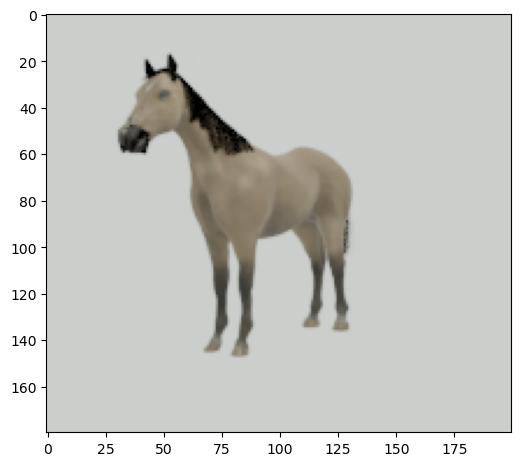

In [6]:
img_index = 150
img = np.array(Image.open(f"{data_dir}/horse_view1_{img_index}.png"))
print(img.shape)
plt.imshow(img[:,:,:3])

In [7]:
# Read the angles
with open(f"{data_dir}/angles.pkl", 'rb') as file:
    angles = pickle.load(file)
angles = jnp.array(angles)

#### Build the data matrices and compute the distance matrices

In [8]:
N = len(angles) 

X1 = []
X2 = []

for i in tqdm(range(N)):
    img_name1 = f"{data_dir}/horse_view1_{i}.png"
    img_name2 = f"{data_dir}/horse_view2_{i}.png"

    img1 = np.array(Image.open(f"{img_name1}"))
    img2 = np.array(Image.open(f"{img_name2}"))
    
    # Ignore the 4th channel (transparency)
    img1 = img1[:,:,:3]
    mig2 = img2[:,:,:3]

    X1.append(img1.reshape(-1).astype(np.float64))
    X2.append(img2.reshape(-1).astype(np.float64))
    
X1 = jnp.array(X1)
X1 = X1/np.max(X1)

X2 = jnp.array(X2)
X2 = X2/np.max(X2)

X1 = X1.T
X2 = X2.T

100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.05it/s]


In [9]:
print(img1.shape)
print(X1.shape)

(180, 200, 3)
(108000, 1000)


In [10]:
A1 = compute_distance_matrix(X1)
A2 = compute_distance_matrix(X2)

100%|██████████████████████████████████████████████████████████████████| 1000/1000 [08:03<00:00,  2.07it/s]


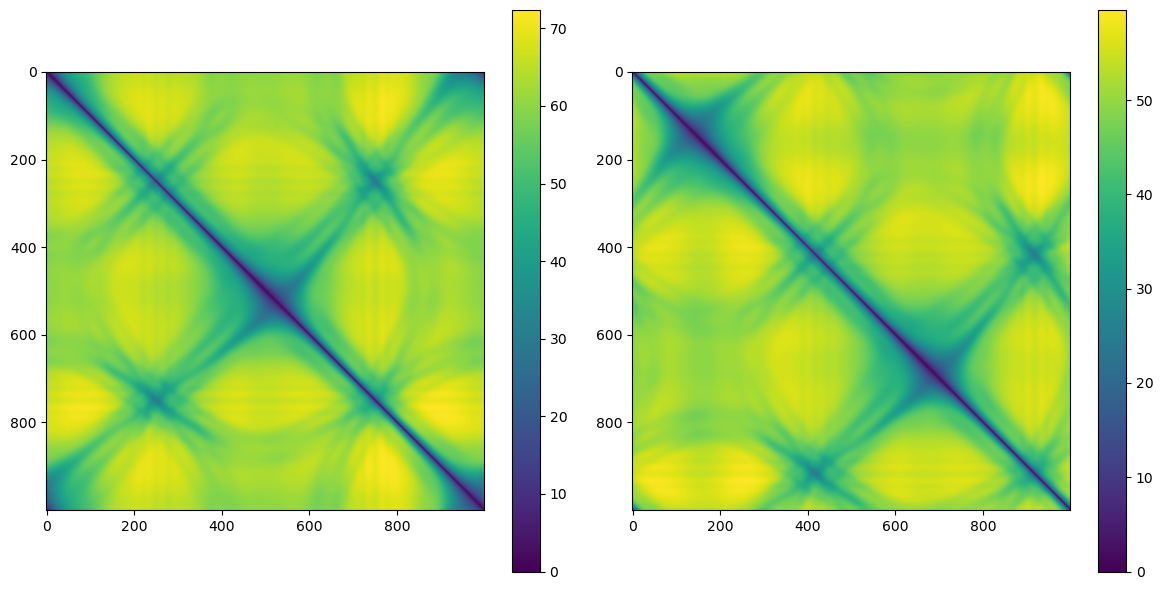

In [11]:
plot_two_matrices(A1, A2)

#### Compute the manifold embedding

In [12]:
eps1 =50

coords1, w1, v1, W1, L1 = compute_embedding(A1, eps1)

In [13]:
eps2 = 50

coords2, w2, v2, W2, L2 = compute_embedding(A2, eps2)

#### First take a look at the DM intermediate steps to make sure all is good

In [14]:
# How many neighbours are 'similar' to each point in the similarity matrix?
# Looking at the point in the 'center' of the list of points

ww1 = W1[N//2]
print(len(ww1[ww1 > 0.1]))

ww2 = W2[N//2]
print(len(ww2[ww2 > 0.1]))

18
5


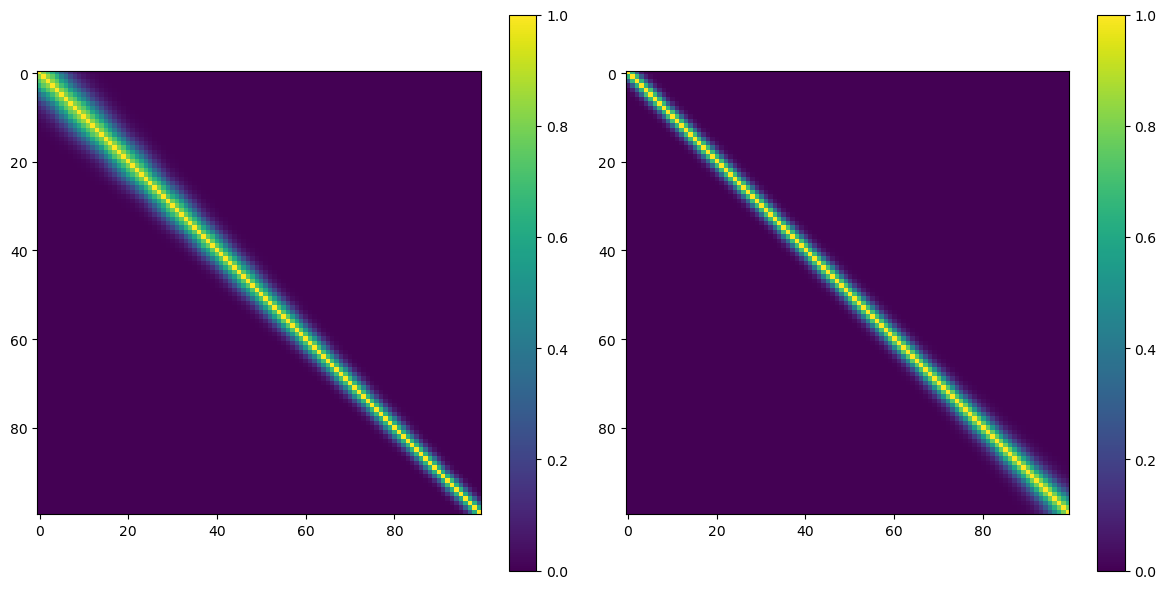

In [15]:
# Plot the similarity matrices, pre-normalization
plot_two_matrices(W1[:100,:100], W2[:100,:100])

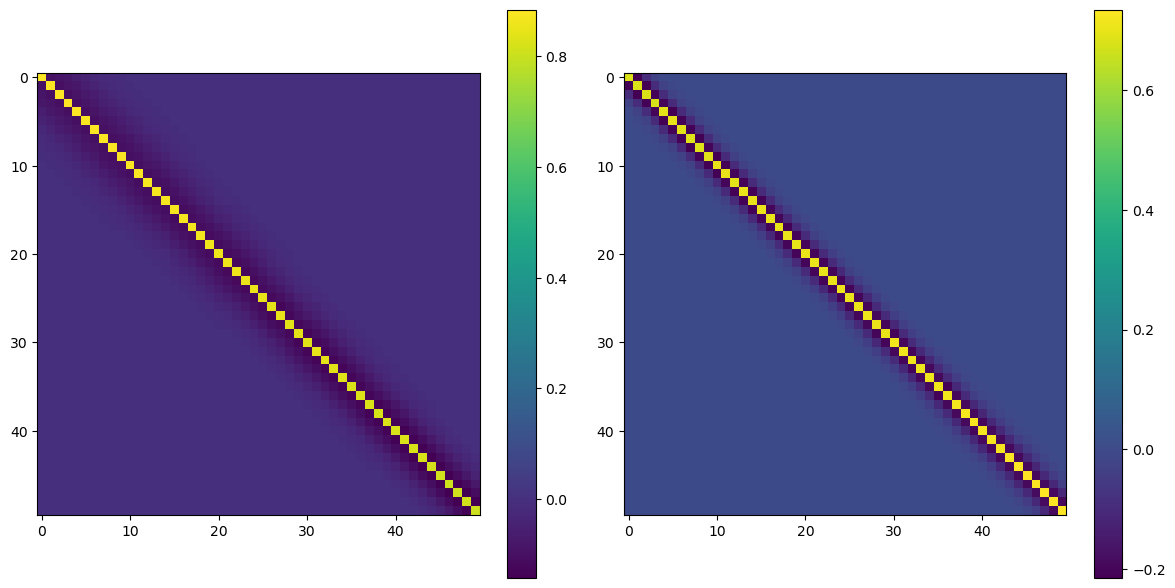

In [16]:
# Plot the final graph Laplacians
plot_two_matrices(L1[:50,:50], L2[:50, :50])

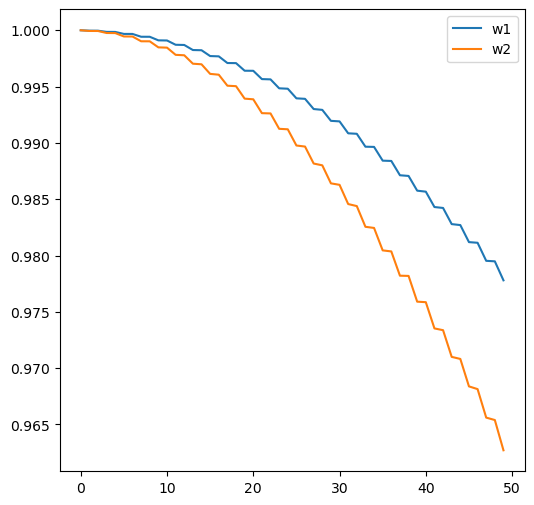

In [17]:
# Plot a few eigenvalues too

plt.plot(w1[:50])
plt.plot(w2[:50])

plt.legend(["w1", "w2"])

In [18]:
print(w1[:10])
print(w2[:10])

[1.         0.99996569 0.99996229 0.99985822 0.99985354 0.99967655
 0.99967506 0.99942476 0.99942323 0.99910579]
[1.         0.99994042 0.99993637 0.9997593  0.99975104 0.99945087
 0.99944682 0.99902351 0.99901962 0.9984831 ]


#### And plot the actual embedding coordinates

In [19]:
savefig = False

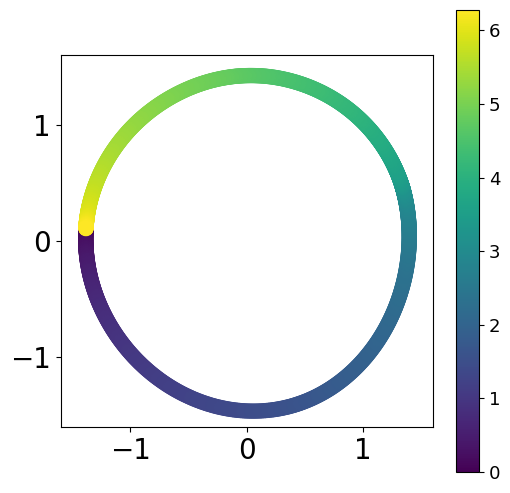

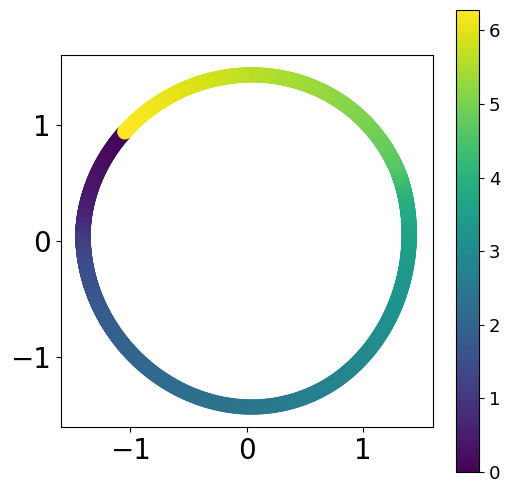

In [20]:
idx1 = 1
idx2 = 2
axis_scale = 1.6
equal_aspect = True

plt.rcParams["figure.figsize"]= 6, 6

fig, ax = plt.subplots(subplot_kw = {'aspect':1})

plt.scatter(coords1[:,idx1], coords1[:,idx2], c = angles, s=100)
cbar = plt.colorbar()

#plt.label(['stuff'])
if equal_aspect:
    plt.xlim(np.array([-1, 1]) * axis_scale)
    plt.ylim(np.array([-1, 1]) * axis_scale)
    
ax.tick_params(axis='both', which='major', labelsize=20)
cbar.ax.tick_params(labelsize=13)

if savefig:
    plt.savefig("embed_simulated_left.eps")
    
######################################################

#plt.subplot(1,2,2)

fig, ax = plt.subplots(subplot_kw = {'aspect':1})

plt.scatter(coords2[:,idx1], coords2[:,idx2], c = angles, s=100)
cbar = plt.colorbar()

if equal_aspect:
    plt.xlim(np.array([-1, 1]) * axis_scale)
    plt.ylim(np.array([-1, 1]) * axis_scale)

ax.tick_params(axis='both', which='major', labelsize=20)
cbar.ax.tick_params(labelsize=13)
    
plt.rcParams["figure.figsize"]= 6,6

if savefig:
    plt.savefig("embed_simulated_right.eps")

#### True angles

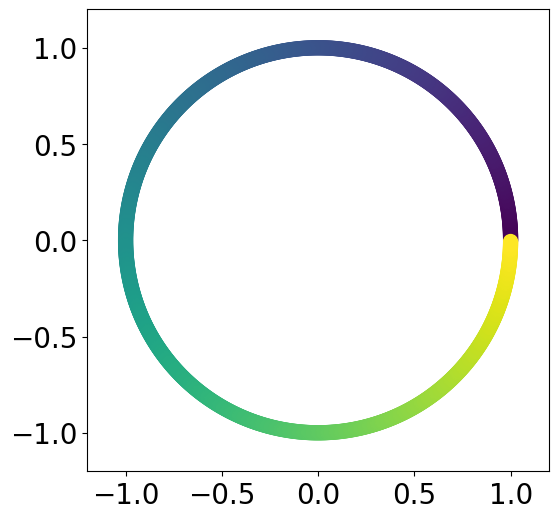

In [21]:
axis_scale = 1.2
equal_aspect = True
fig, ax = plt.subplots(subplot_kw = {'aspect':1})

plt.scatter(jnp.cos(angles), jnp.sin(angles), c = angles, s=100)

if equal_aspect:
    plt.xlim(np.array([-1, 1]) * axis_scale)
    plt.ylim(np.array([-1, 1]) * axis_scale)

ax.tick_params(axis='both', which='major', labelsize=20)
    
plt.rcParams["figure.figsize"]= 6,6

if savefig:
    plt.savefig("simulated_true_angles.eps")

### Density plots

In [22]:
emb1 = coords1[:,1:3]
emb2 = coords2[:,1:3]

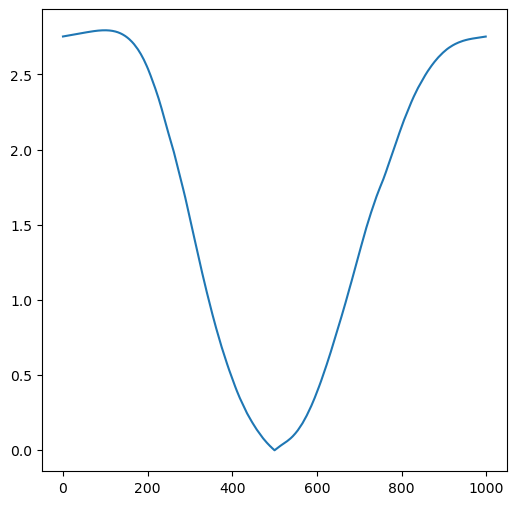

In [23]:
# Plot the distances between coordinates to set r    
dists_i = jax.vmap(lambda pt0, pti : jnp.linalg.norm(pt0-pti), in_axes = (None, 0))(emb1[500], emb1)
plt.plot(dists_i)

In [24]:
r = 0.05

density1 = compute_density(emb1, r)
density2 = compute_density(emb2, r)

In [25]:
# For better plotting, sort based on density and then plot the points in that order
idx_sorted_density1 = jnp.argsort(density1)
idx_sorted_density2 = jnp.argsort(density2)

In [26]:
savefig = False

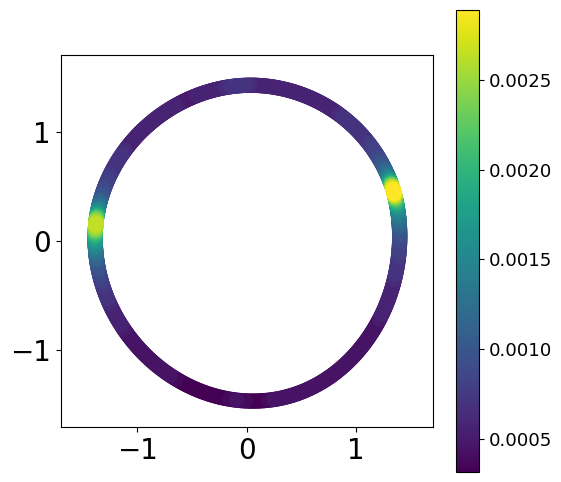

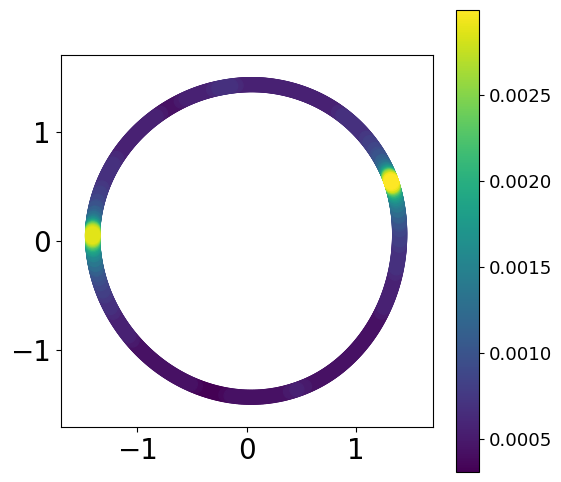

In [27]:
axis_scale = 1.7
equal_aspect = True

plt.rcParams["figure.figsize"]= 6,6

fig, ax = plt.subplots(subplot_kw = {'aspect':1})

plt.scatter(emb1[idx_sorted_density1,0], emb1[idx_sorted_density1,1], c = density1[idx_sorted_density1], s=100, cmap='viridis')
cbar = plt.colorbar()

if equal_aspect:
    plt.xlim(np.array([-1, 1]) * axis_scale)
    plt.ylim(np.array([-1, 1]) * axis_scale)
    
ax.tick_params(axis='both', which='major', labelsize=20)
cbar.ax.tick_params(labelsize=13)

if savefig:
    plt.savefig(f"embed_density_simulated_left_r{r}.eps")

###################################################################################

fig, ax = plt.subplots(subplot_kw = {'aspect':1})

plt.scatter(emb2[idx_sorted_density2,0], emb2[idx_sorted_density2,1], c = density2[idx_sorted_density2], s=100, cmap='viridis')
cbar = plt.colorbar()

if equal_aspect:
    plt.xlim(np.array([-1, 1]) * axis_scale)
    plt.ylim(np.array([-1, 1]) * axis_scale)

ax.tick_params(axis='both', which='major', labelsize=20)
cbar.ax.tick_params(labelsize=13)
 
if savefig:
    plt.savefig(f"embed_density_simulated_right_r{r}.eps")
    
plt.rcParams["figure.figsize"]= 6,6

(180, 200, 4)


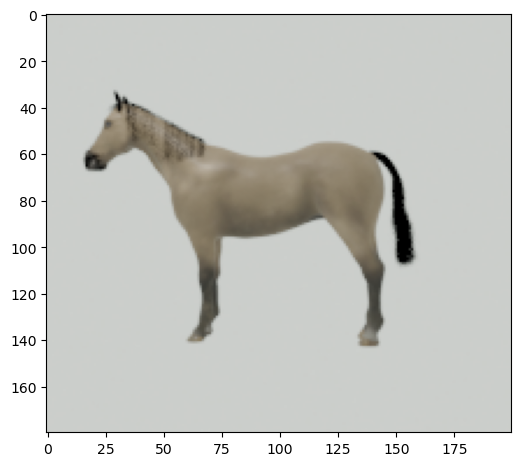

In [28]:
img_index = 150 #jnp.argmax(density1)
img = np.array(Image.open(f"{data_dir}/horse_view2_{img_index}.png"))
print(img.shape)
plt.imshow(img[:,:,:3])

150
0.00044008550232616623


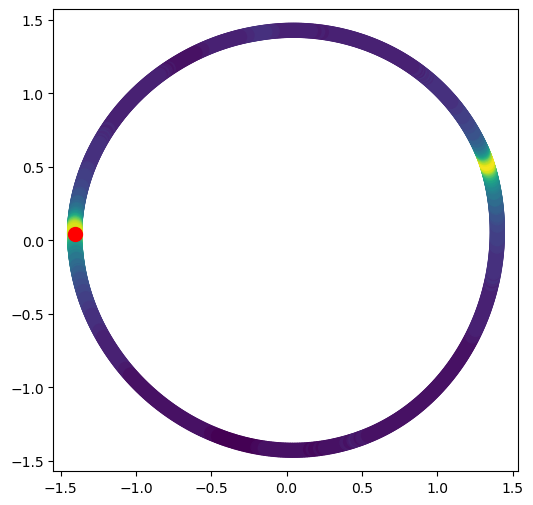

In [29]:
print(img_index)
print(density1[img_index])
plt.scatter(emb2[:,0], emb2[:,1], c = density2, s=100, cmap='viridis')
plt.scatter(emb2[img_index,0], emb2[img_index,1], s = 100, c='r')
#cbar = plt.colorbar()


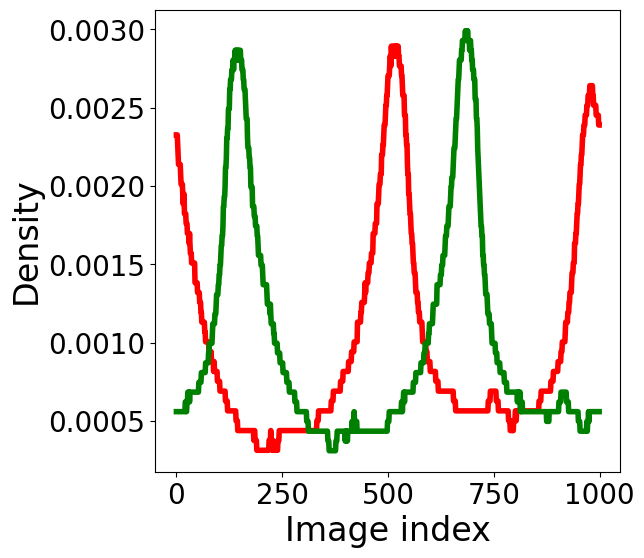

In [30]:
# And the distribution of the estimated angles based on the computation above

nbins = 100

plt.rcParams["figure.figsize"]= 6,6

fig, ax = plt.subplots()

plt.plot(density1, color = 'r', alpha=1, linewidth=4)
plt.plot(density2, color = 'g', alpha=1, linewidth=4)
#bins_true, _, _ = plt.hist(np.array(angles), nbins, density=True, histtype = 'step', alpha=1, linewidth=4)

plt.xlabel("Image index", fontsize=24)
plt.ylabel("Density", fontsize=24)

#plt.legend(["Angles left", "Angles right", "Angles true"], loc = (0.17,0.67), fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=20)

if savefig:
    plt.savefig(f"emb_densities_simulated_r{r}.eps", bbox_inches='tight')
    
plt.rcParams["figure.figsize"]= 6,6    

### Density in Y 

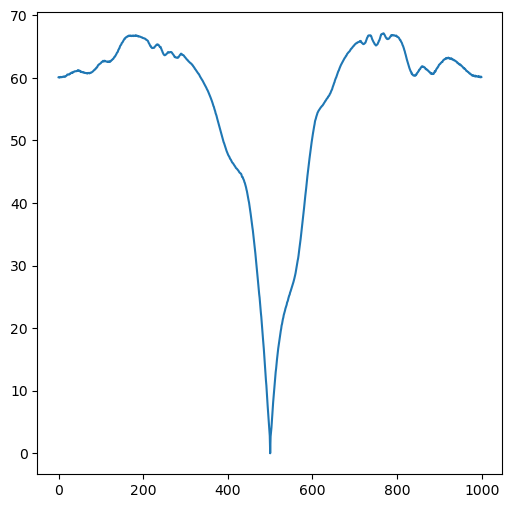

In [31]:
plt.plot(A1[500])

In [32]:
# rY is chosen so that the maximum density in Y is the same as the maximum desnsity in the embedding
rY = 9
density_Y1 = compute_density_Y(A1,rY)
print(jnp.max(density_Y1))
print(jnp.max(density1))

0.0028257978723404257
0.002891990443857664


In [33]:
# For better plotting, sort based on density and then plot the points in that order
idx_sorted_density_Y1 = jnp.argsort(density_Y1)

In [34]:
savefig = False

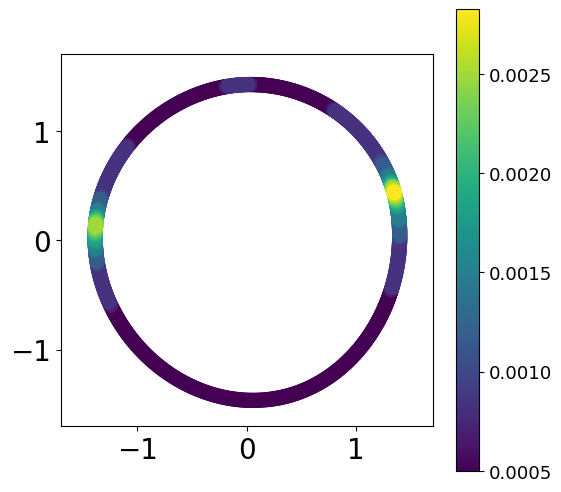

In [35]:
axis_scale = 1.7
equal_aspect = True

plt.rcParams["figure.figsize"]= 6,6

fig, ax = plt.subplots(subplot_kw = {'aspect':1})

plt.scatter(emb1[idx_sorted_density_Y1,0], emb1[idx_sorted_density_Y1,1], c = density_Y1[idx_sorted_density_Y1], s=100, cmap='viridis')
cbar = plt.colorbar()

if equal_aspect:
    plt.xlim(np.array([-1, 1]) * axis_scale)
    plt.ylim(np.array([-1, 1]) * axis_scale)
    
ax.tick_params(axis='both', which='major', labelsize=20)
cbar.ax.tick_params(labelsize=13)

if savefig:
    plt.savefig(f"Y_density_simulated_left_r{rY}.eps")